In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import time
from PIL import Image
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv2D, Flatten, Dense

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [3]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

X_train.shape, X_valid.shape

((42500, 32, 32, 3), (7500, 32, 32, 3))

# Settings

In [5]:
GLOBAL_BATCHSIZE = 32

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

# Visualization

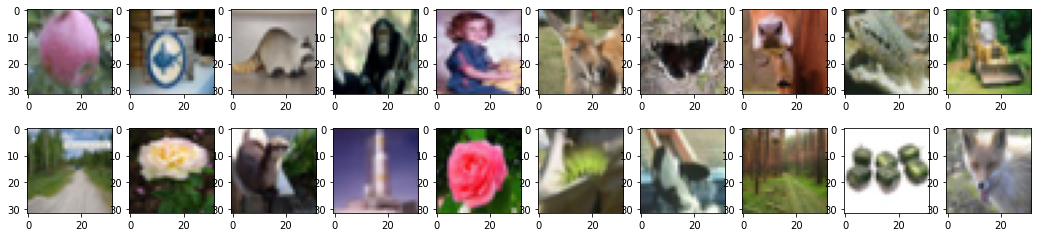

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 4))

for i in range(1, 21):
    plt.subplot(2, 10, i)
    plt.imshow(X_train[i-1])
    
plt.show()

# Train dataloader

In [7]:
def train_preprocessing(train_images, train_labels):
    # train image
    train_images = tf.cast(train_images, dtype = tf.float32)
    
    # random crop
    train_images = tf.image.resize(train_images, (224, 224))
    train_images = tf.keras.applications.vgg16.preprocess_input(train_images)
    
    # augmentation
    rotated = tf.random.uniform((), 0, 3, dtype=tf.int32)
        
    if rotated == 0:
        train_images = tf.image.rot90(train_images, k=1)
    elif rotated == 1:
        train_images = tf.image.rot90(train_images, k=2)
    elif rotated == 2:
        train_images = tf.image.rot90(train_images, k=3)
        
    train_images = tf.image.random_flip_left_right(train_images)
    train_images = tf.image.random_flip_up_down(train_images)
    
    # jitter
    train_images = tf.image.random_brightness(train_images, 0.3)
#     train_images = tf.image.random_contrast(train_images, 0.2, 0.5)
#     train_images = tf.image.random_saturation(train_images, 2, 5)
    
    return train_images, train_labels

# Valid dataloader

In [8]:
def valid_preprocessing(valid_images, valid_labels):
    # train image
    valid_images = tf.cast(valid_images, dtype = tf.float32)
    
    # image resize
    valid_images = tf.image.resize(valid_images, (224, 224))
    valid_images = tf.keras.applications.vgg16.preprocess_input(valid_images)
    
    return valid_images, valid_labels

# Test dataloader

In [9]:
def test_preprocessing(test_images, test_labels):
    # train image
    test_images = tf.cast(test_images, dtype = tf.float32)
    
    # image resize
    test_images = tf.image.resize(test_images, (224, 224))
    test_images = tf.keras.applications.vgg16.preprocess_input(test_images)
    
    return test_images, test_labels

# Compute class weight

In [10]:
from sklearn.utils.class_weight import compute_class_weight

class_w = compute_class_weight(class_weight = "balanced", 
                     classes=np.unique(y_train), 
                     y = np.squeeze(y_train))

cls_weight = {}

for i, w in enumerate(class_w):
    cls_weight[i] = w

In [11]:
cls_weight

{0: 0.9976525821596244,
 1: 1.0023584905660377,
 2: 1.009501187648456,
 3: 0.9976525821596244,
 4: 0.9550561797752809,
 5: 1.0119047619047619,
 6: 1.0265700483091786,
 7: 1.0,
 8: 0.9929906542056075,
 9: 0.9725400457665904,
 10: 1.009501187648456,
 11: 0.9883720930232558,
 12: 1.0023584905660377,
 13: 0.9929906542056075,
 14: 1.0047281323877069,
 15: 1.0071090047393365,
 16: 1.009501187648456,
 17: 0.9747706422018348,
 18: 1.0167464114832536,
 19: 1.0023584905660377,
 20: 1.009501187648456,
 21: 0.9860788863109049,
 22: 1.0240963855421688,
 23: 0.9883720930232558,
 24: 1.0240963855421688,
 25: 1.0216346153846154,
 26: 0.9837962962962963,
 27: 1.0143198090692125,
 28: 0.9953161592505855,
 29: 0.9953161592505855,
 30: 0.9770114942528736,
 31: 1.0,
 32: 1.009501187648456,
 33: 1.0143198090692125,
 34: 1.0191846522781776,
 35: 0.9815242494226328,
 36: 1.0315533980582525,
 37: 1.0,
 38: 1.0,
 39: 0.9929906542056075,
 40: 1.0265700483091786,
 41: 1.009501187648456,
 42: 1.0216346153846154,
 

# Implement VGG

In [12]:
def conv_bn_act(get_list, filters):
    get_list.append(layers.Conv2D(filters, 3, 1, padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.0005), kernel_initializer='he_normal', use_bias=True))
    get_list.append(layers.BatchNormalization())
    get_list.append(layers.ReLU())
    
    return get_list

def VGG(num_layers, num_filters, num_class):
    # list append -> Sequential 형태로 구현 ( 복잡한 구조는 다른 방식을 활용 )
    vgg_layers = []
    vgg_layers.append(layers.Input((224, 224, 3)))
    
    for num, ft in zip(num_layers, num_filters):
        for i in range(num):
            vgg_layers = conv_bn_act(vgg_layers, ft)
        vgg_layers.append(layers.MaxPooling2D((2, 2), 2))
        
    vgg_layers.append(layers.Flatten())
    vgg_layers.append(layers.Dense(4096, activation='relu'))
    vgg_layers.append(layers.Dropout(0.7))
    vgg_layers.append(layers.Dense(4096, activation='relu'))
    vgg_layers.append(layers.Dropout(0.7))
    vgg_layers.append(layers.Dense(num_class))
        
    return vgg_layers

def Constructor(version):
    if version == 'VGG16':
        model = VGG([2, 2, 3, 3, 3], [64, 128, 256, 512, 512], 100)
    elif version == 'VGG19':
        model = VGG([2, 2, 4, 4, 4], [64, 128, 256, 512, 512], 100)
            
    return tf.keras.Sequential(model)

In [13]:
model = Constructor('VGG16')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0

# Define dataloader

In [15]:
STEPS_PER_EPOCH = X_train.shape[0] // GLOBAL_BATCHSIZE
VALID_STEPS_PER_EPOCH = X_valid.shape[0] // GLOBAL_BATCHSIZE

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.map(train_preprocessing)
train_dataset = train_dataset.batch(GLOBAL_BATCHSIZE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(len(X_valid))
valid_dataset = valid_dataset.map(valid_preprocessing)
valid_dataset = valid_dataset.batch(GLOBAL_BATCHSIZE)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

for i, j in train_dataset.take(1):
    print(i.shape, j.shape)

(32, 224, 224, 3) (32, 1)


# Compile & training

In [ ]:
model = Constructor('VGG16')

def scheduler(epoch, lr):
    if epoch % 10 == 0:
        return lr * 0.92
    else:
        return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9), metrics=['accuracy'])

history = model.fit(train_dataset, epochs=500, batch_size=GLOBAL_BATCHSIZE,
                    validation_data=valid_dataset,steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALID_STEPS_PER_EPOCH,
                    callbacks=[lr_callback, early_stop], class_weight=cls_weight)

Epoch 1/500
1328/1328 [==============================] - 244s 178ms/step - loss: 18.1092 - accuracy: 0.0116 - val_loss: 8.8127 - val_accuracy: 0.0148
Epoch 2/500
1328/1328 [==============================] - 237s 178ms/step - loss: 9.3518 - accuracy: 0.0086 - val_loss: 8.3716 - val_accuracy: 0.0112
Epoch 3/500
1328/1328 [==============================] - 238s 179ms/step - loss: 8.1542 - accuracy: 0.0099 - val_loss: 7.5540 - val_accuracy: 0.0097
Epoch 4/500
1328/1328 [==============================] - 311s 234ms/step - loss: 7.3841 - accuracy: 0.0089 - val_loss: 6.9142 - val_accuracy: 0.0107
Epoch 5/500
1328/1328 [==============================] - 414s 312ms/step - loss: 6.7822 - accuracy: 0.0093 - val_loss: 6.4134 - val_accuracy: 0.0116
Epoch 6/500
1253/1328 [===========================>..] - ETA: 22s - loss: 6.3152 - accuracy: 0.0091